In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import pandas as pd
from scipy.optimize import fsolve

# Q1 - Binomial Tree Methods for Derivatives Valuation and Hedging Parameters Computation

In [2]:
def d1(S, K, T, r, q, sigma):
    """Calculates d1 (BSM)."""
    return (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))

def d2(S, K, T, r, q, sigma, d1_val=None):
    """Calculates d2 (BSM)."""
    if d1_val is None:
        d1_val = d1(S, K, T, r, q, sigma)
    return d1_val - sigma * math.sqrt(T)

def bs_call(S, K, T, r, q, sigma):
    """Calculate the value for a European call option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return S * math.exp(-q * T) * norm.cdf(d1_val) - K * math.exp(-r * T) * norm.cdf(d2_val)

def bs_put(S, K, T, r, q, sigma):
    """Calculate the value for a European put option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return K * math.exp(-r * T) * norm.cdf(-d2_val) - S * math.exp(-q * T) * norm.cdf(-d1_val)

def u_(T, sigma, N):
    """S1 = S0 * u_"""
    dt = T/N
    return np.exp(sigma*np.sqrt(dt))

def d_(T, sigma, N):
    """S1 = S0 * d_"""
    return 1 / u_(T, sigma, N)

In [3]:
def payoffs(V, i, S_temp, K, flag1):
    if flag1: ## Put.
        V[i] = max(K - S_temp, 0)
    else: ## Call.
        V[i] = max(S_temp - K, 0)

In [4]:
def binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1)
        S_temp2 *= u_bar
    
    ## Work backwards through the tree.
    for j in range(N - 1, -1, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar
    return V[0]

In [5]:
def avg_binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) + binomial_pricer(S0, K, T, r, q, sigma, N-1, flag1, flag2))/2 ## Simple average.

In [6]:
def BBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = (N-1)//2
    if not (N-1) % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        if not flag1: ## Call option.
            V[i] = bs_call(S_temp1, K, dt, r, q, sigma)
        else: ## Put option.
            V[i] = bs_put(S_temp1, K, dt, r, q, sigma)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N):
        if not flag1:
            V[i] = bs_call(S_temp2, K, dt, r, q, sigma)
        else:
            V[i] = bs_put(S_temp2, K, dt, r, q, sigma)
        S_temp2 *= u_bar
            
    ## Work backwards through the tree.
    for j in range(N - 2, -1, -1):
        if flag2: ## American option.
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar

    return V[0]

In [7]:
def BBSN_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (2*BBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) - BBS_pricer(S0, K, T, r, q, sigma, N//2+1, flag1, flag2))

In [8]:
## Option Parameters. ##
S0 = 54
K = 50
T = 1
r = 0.0375
q = 0.01
sigma = 0.29

## Number of time steps to use.
N = np.array([x for x in range(10,101)])

# Arrays for European Put Option Pricing
EP_BT = np.empty(len(N))
EP_ABT = np.empty(len(N))
EP_BBS = np.empty(len(N))
EP_BBSR = np.empty(len(N))

# Arrays for American Put Option Pricing
AP_BT = np.empty(len(N))
AP_ABT = np.empty(len(N))
AP_BBS = np.empty(len(N))
AP_BBSR = np.empty(len(N))

for i in range(len(N)):
    ## European Put Option Pricing.
    EP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_BBS[i] = BBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_BBSR[i] = BBSN_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    
    ## American Put Option Pricing.
    AP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_BBS[i] = BBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_BBSR[i] = BBSN_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)

print("BS put price:", bs_put(S0, K, T, r, q, sigma))

BS put price: 3.5794281157157926


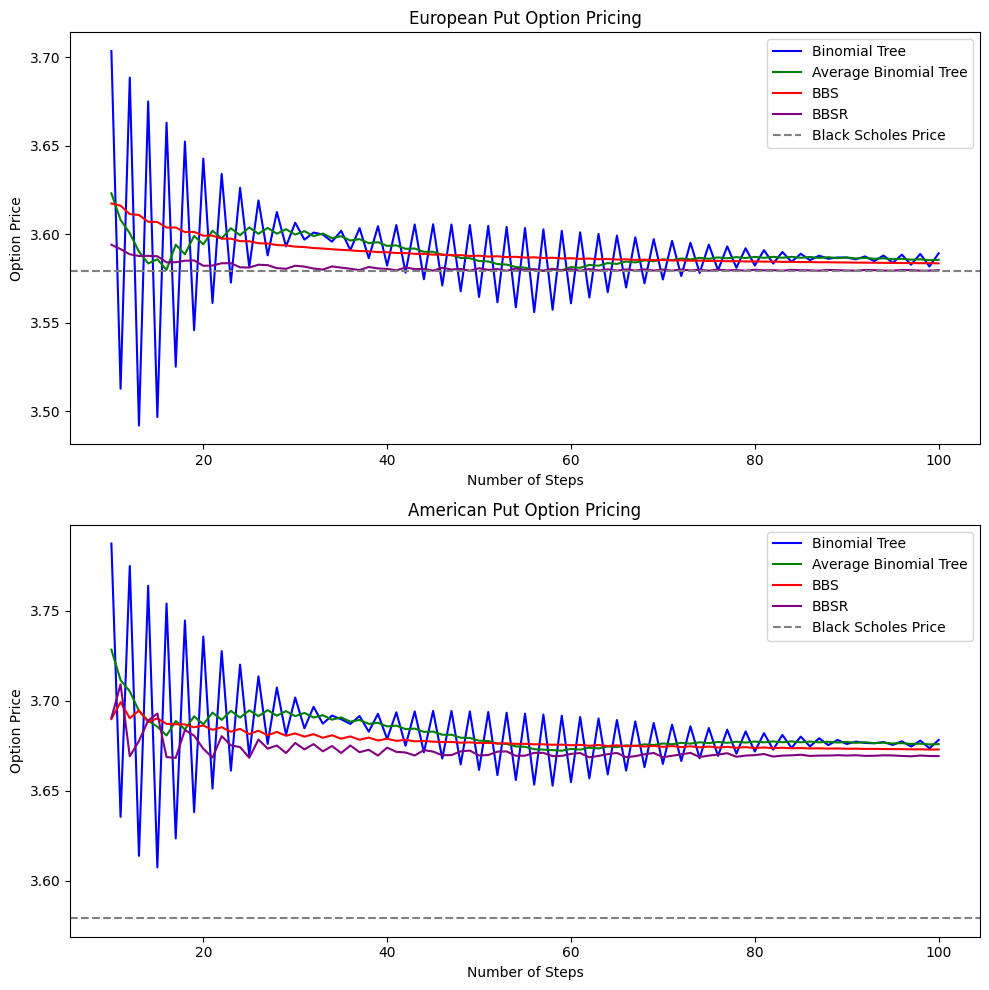

In [9]:
## Plotting Results ##
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# European Put Option Pricing Plot
ax[0].plot(N, EP_BT, label="Binomial Tree", color='blue')
ax[0].plot(N, EP_ABT, label="Average Binomial Tree", color='green')
ax[0].plot(N, EP_BBS, label="BBS", color='red')
ax[0].plot(N, EP_BBSR, label="BBSR", color='purple')
ax[0].axhline(y=bs_put(S0, K, T, r, q, sigma), color='grey', linestyle='--', label="Black Scholes Price")
ax[0].set_title("European Put Option Pricing")
ax[0].set_xlabel("Number of Steps")
ax[0].set_ylabel("Option Price")
ax[0].legend()

# American Put Option Pricing Plot
ax[1].plot(N, AP_BT, label="Binomial Tree", color='blue')
ax[1].plot(N, AP_ABT, label="Average Binomial Tree", color='green')
ax[1].plot(N, AP_BBS, label="BBS", color='red')
ax[1].plot(N, AP_BBSR, label="BBSR", color='purple')
ax[1].axhline(y=bs_put(S0, K, T, r, q, sigma), color='grey', linestyle='--', label="Black Scholes Price")
ax[1].set_title("American Put Option Pricing")
ax[1].set_xlabel("Number of Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()

plt.tight_layout()
plt.show()


In [10]:
## Create DataFrames for European and American put option estimates.
european_df = pd.DataFrame({
    'N': N,
    'BT': EP_BT,
    'ABT': EP_ABT,
    'BBS': EP_BBS,
    'BBSR': EP_BBSR
})

american_df = pd.DataFrame({
    'N': N,
    'BT': AP_BT,
    'ABT': AP_ABT,
    'BBS': AP_BBS,
    'BBSR': AP_BBSR
})

## Write DataFrames to Excel with one blank row in between.
with pd.ExcelWriter('Put_Estimates.xlsx', engine='openpyxl') as writer:
    european_df.to_excel(writer, sheet_name='Put Estimates', startrow=0, index=False)
    american_df.to_excel(writer, sheet_name='Put Estimates', startrow=len(european_df) + 2, index=False)

print("Data saved to Excel file.")

Data saved to Excel file.


# Q2 - Binomial Tree Methods for European Options

In [11]:
import numpy as np
import pandas as pd 
np.set_printoptions(precision=6)
pd.set_option(
    "display.precision", 6, 
    "display.float_forma", '{:.6f}'.format
)
from enum import IntEnum
from itertools import accumulate
from operator import mul
import unittest
from pprint import pprint

In [12]:
class CallPutType(IntEnum):
    Call = 0
    Put = 1
    
class EuroAmerType(IntEnum):
    EuropeanOption = 0
    AmericanOption = 1
    
def generate_geometric_sequence(start, ratio, length):
    """
    e.g. start = 10, ratio = 2, length = 5
    return [10, 20, 40, 80, 160]
    """
    progression = np.empty(length, dtype=int)
    for i in range(0, length):
        curr_term = start * pow(ratio, i)
        progression[i] = int(curr_term)
    return progression

def delta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        delta = np.exp(-q*T) * norm.cdf(d1_val)
    elif call_put_type == CallPutType.Put:
        delta = -np.exp(-q*T) * norm.cdf(-d1_val)
    else:
        raise ValueError("invalid call_put_type")
    return delta

def delta_1(V_1_0, V_1_1, S_1_0, S_1_1):
    return (V_1_0 - V_1_1) / (S_1_0 - S_1_1)

def gamma_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    # gammas of C and P are the same for european options
    gamma = np.exp(-q*T) / (S*sigma*np.sqrt(T)) * (1/np.sqrt(2*np.pi)) * np.exp(-d1_val**2/2)
    return gamma

def gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2):
    upper_1 = (V_2_0 - V_2_1) / (S_2_0 - S_2_1)
    upper_2 = (V_2_1 - V_2_2) / (S_2_1 - S_2_2)
    lower = (S_2_0 - S_2_2) / 2
    return (upper_1 - upper_2) / lower

def vega_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    # vegas of C and P are the same for european options
    vega = S * np.exp(-q*T) * np.sqrt(T) * (1/np.sqrt(2*np.pi)) * np.exp(-d1_val**2/2)
    return vega 

def theta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2)
            + q * S * np.exp(-q*T) * norm.cdf(d1_val)
            - r * K * np.exp(-r*T) * norm.cdf(d2_val)
        )
    elif call_put_type == CallPutType.Put:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2) 
            - q * S * np.exp(-q*T) * norm.cdf(-d1_val) 
            + r * K * np.exp(-r*T) * norm.cdf(-d2_val)
        )
    else:
        raise ValueError("Invalid call_put_type")
    return theta

def theta_1(V_2_1, V_0_0, T, N):
    dt = T/N
    return (V_2_1 - V_0_0) / (2*dt)

def binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    """
    This is a modication of Kevin's binomial pricer
    In order to get V_1_0, V_1_1, V_2_0, V_2_1, V_2_2, ...
    Args:
        early_stop: the nth step from V_0
    """
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1)
        S_temp2 *= u_bar
    
    ## Work backwards through the tree.
    for j in range(N - 1, -1+early_stop, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar
    return V[:(early_stop+1)]

In [13]:
class TestNotebook(unittest.TestCase):
    
    def test_generate_geometric_sequence(self):
        sequence = generate_geometric_sequence(10, 2, 5)
        assert np.array_equal(
            sequence, 
            [10, 20, 40, 80, 160]
        )
        
    def test_binomial_pricer_early_stop(self):
        S0 = 54
        K = 50
        T = 1
        r = 0.0375
        q = 0.01
        sigma = 0.29
        N = 100
        
        reference = binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, early_stop=0)[0]
        target = binomial_pricer(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption)
        assert np.isclose(reference, target)
        
    def test_binomial_pricer_early_stop_order(self):
        S0 = 54
        K = 50
        T = 1
        r = 0.0375
        q = 0.01
        sigma = 0.29
        N = 100
        
        values = binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, early_stop=2)
        assert len(values) == 3
        assert values[0] >= values[1] and values[1] >= values[2]
        
    def test_u_d(self):
        T = 1
        sigma = 0.29
        N = 100
        u = u_(T, sigma, N)
        d = d_(T, sigma, N)
        assert np.isclose(u*d, 1.0)


unittest.main(argv=[''], verbosity=6, exit=False)

test_binomial_pricer_early_stop (__main__.TestNotebook.test_binomial_pricer_early_stop) ... ok
test_binomial_pricer_early_stop_order (__main__.TestNotebook.test_binomial_pricer_early_stop_order) ... ok
test_generate_geometric_sequence (__main__.TestNotebook.test_generate_geometric_sequence) ... ok
test_u_d (__main__.TestNotebook.test_u_d) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.015s

OK


### Black Scholes Pricing

In [14]:
V_BS = bs_put(S0, K, T, r, q, sigma)
Delta_BS = delta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put) 
Gamma_BS = gamma_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)
Theta_BS = theta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)

black_scholes_res = pd.DataFrame({
    "V_BS": V_BS,
    "Delta_BS": Delta_BS,
    "Gamma_BS": Gamma_BS,
    "Theta_BS": Theta_BS,
}, index=[0])
pprint(black_scholes_res)


      V_BS  Delta_BS  Gamma_BS  Theta_BS
0 3.579428 -0.303654  0.022200 -2.136950


In [15]:
def approximation_error(reference, target):
    return abs(reference-target)

def approximation_error_true(reference, target):
    """
    keep the signal of the error, used in the variance reduction of American options
    """
    return reference-target

def linear_approximation_error(reference, target, N):
    return N * approximation_error(reference, target)

def quadratic_approximation_error(reference, target, N):
    return N**2 * approximation_error(reference, target)

### Binomial Tree

In [16]:
# Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BT = np.empty(len(N))
EP_BT_approximation_error = np.empty(len(N))
EP_BT_linear_approximation_error = np.empty(len(N))
EP_BT_quadratic_approximation_error = np.empty(len(N))

EP_BT_delta = np.empty(len(N))
EP_BT_delta_error = np.empty(len(N))
EP_BT_gamma = np.empty(len(N))
EP_BT_gamma_error = np.empty(len(N))
EP_BT_theta = np.empty(len(N))
EP_BT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    
    # approximation error
    EP_BT_approximation_error[i] = approximation_error(EP_BT[i], V_BS)
    EP_BT_linear_approximation_error[i] = linear_approximation_error(EP_BT[i], V_BS, N[i])
    EP_BT_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BT[i], V_BS, N[i])
    
    EP_BT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BT_delta_error[i] = approximation_error(EP_BT_delta[i] , Delta_BS)
    EP_BT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BT_gamma_error[i] = approximation_error(EP_BT_gamma[i], Gamma_BS)
    EP_BT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BT_theta_error[i] = approximation_error(EP_BT_theta[i], Theta_BS)
    
binomial_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BT,
    "|V(N) - V_BS|": EP_BT_approximation_error, 
    "N|V(N) - V_BS|": EP_BT_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BT_quadratic_approximation_error,
    "Delta_1": EP_BT_delta,
    "|Delta_1 - Delta_BS|": EP_BT_delta_error,
    "Gamma_1": EP_BT_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BT_gamma_error,
    "Theta_1": EP_BT_theta,
    "|Theta_1 - Theta_BS|": EP_BT_theta_error,
})

binomial_tree_res

,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.703631,0.124202,1.242025,12.420250,0.306502,0.610156,0.011641,0.010559,-2.227566,0.090616
1,20,3.642832,0.063404,1.268083,25.361669,0.304525,0.608179,0.011277,0.010923,-2.178015,0.041065
2,40,3.582311,0.002882,0.115300,4.611987,0.303623,0.607277,0.011238,0.010962,-2.172174,0.035224
3,80,3.582365,0.002936,0.234918,18.793401,0.303807,0.607461,0.011089,0.011111,-2.154212,0.017262
4,160,3.585679,0.006251,1.000199,160.031855,0.303748,0.607402,0.011000,0.011199,-2.142895,0.005945
5,320,3.583016,0.003588,1.148124,367.399785,0.303721,0.607375,0.010975,0.011225,-2.139740,0.002790
6,640,3.581148,0.001719,1.100460,704.294342,0.303686,0.607339,0.010965,0.011235,-2.138379,0.001429
7,1280,3.579952,0.000524,0.671047,858.940688,0.303663,0.607317,0.010960,0.011240,-2.137825,0.000876


### Average Black-Scholes Tree

In [17]:
def avg_binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (
        binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop) 
        + binomial_pricer_early_stop(S0, K, T, r, q, sigma, N-1, flag1, flag2, early_stop)
    )/2 ## Simple average.

In [18]:
# Average Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_ABT = np.empty(len(N))
EP_ABT_approximation_error = np.empty(len(N))
EP_ABT_linear_approximation_error = np.empty(len(N))
EP_ABT_quadratic_approximation_error = np.empty(len(N))

EP_ABT_delta = np.empty(len(N))
EP_ABT_delta_error = np.empty(len(N))
EP_ABT_gamma = np.empty(len(N))
EP_ABT_gamma_error = np.empty(len(N))
EP_ABT_theta = np.empty(len(N))
EP_ABT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = avg_binomial_pricer(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    
    # approximation error
    EP_ABT_approximation_error[i] = approximation_error(EP_ABT[i], V_BS)
    EP_ABT_linear_approximation_error[i] = linear_approximation_error(EP_ABT[i], V_BS, N[i])
    EP_ABT_quadratic_approximation_error[i] = quadratic_approximation_error(EP_ABT[i], V_BS, N[i])
    
    EP_ABT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_ABT_delta_error[i] = approximation_error(EP_ABT_delta[i] , Delta_BS)
    EP_ABT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_ABT_gamma_error[i] = approximation_error(EP_ABT_gamma[i], Gamma_BS)
    EP_ABT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_ABT_theta_error[i] = approximation_error(EP_ABT_theta[i], Theta_BS)
    
average_binomial_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_ABT,
    "|V(N) - V_BS|": EP_ABT_approximation_error, 
    "N|V(N) - V_BS|": EP_ABT_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_ABT_quadratic_approximation_error,
    "Delta_1": EP_ABT_delta,
    "|Delta_1 - Delta_BS|": EP_ABT_delta_error,
    "Gamma_1": EP_ABT_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_ABT_gamma_error,
    "Theta_1": EP_ABT_theta,
    "|Theta_1 - Theta_BS|": EP_ABT_theta_error,
})

average_binomial_tree_res

,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.623203,0.043775,0.437746,4.377459,0.297369,0.601022,0.011342,0.010858,-2.167177,0.030227
1,20,3.594339,0.014911,0.298211,5.964216,0.300565,0.604219,0.011106,0.011094,-2.146797,0.009847
2,40,3.593456,0.014028,0.561109,22.444364,0.302062,0.605716,0.011016,0.011184,-2.139979,0.003029
3,80,3.587250,0.007822,0.625780,50.062433,0.302869,0.606523,0.010984,0.011216,-2.138349,0.001399
4,160,3.583019,0.003591,0.574518,91.922843,0.303261,0.606915,0.010968,0.011232,-2.137526,0.000576
5,320,3.580991,0.001562,0.499971,159.990793,0.303449,0.607103,0.010962,0.011238,-2.137445,0.000495
6,640,3.580267,0.000839,0.536713,343.496566,0.303553,0.607206,0.010958,0.011242,-2.137160,0.000210
7,1280,3.579932,0.000504,0.644682,825.193216,0.303605,0.607258,0.010955,0.011245,-2.137001,0.000051


### Binomial Black-Scholes

In [19]:
def BBS_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = (N-1)//2
    if not (N-1) % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        if not flag1: ## Call option.
            V[i] = bs_call(S_temp1, K, dt, r, q, sigma)
        else: ## Put option.
            V[i] = bs_put(S_temp1, K, dt, r, q, sigma)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N):
        if not flag1:
            V[i] = bs_call(S_temp2, K, dt, r, q, sigma)
        else:
            V[i] = bs_put(S_temp2, K, dt, r, q, sigma)
        S_temp2 *= u_bar
            
    ## Work backwards through the tree.
    for j in range(N - 2, -1+early_stop, -1):
        if flag2: ## American option.
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar

    return V[:(early_stop+1)]

In [20]:
# Black Scholes Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BBS = np.empty(len(N))
EP_BBS_approximation_error = np.empty(len(N))
EP_BBS_linear_approximation_error = np.empty(len(N))
EP_BBS_quadratic_approximation_error = np.empty(len(N))

EP_BBS_delta = np.empty(len(N))
EP_BBS_delta_error = np.empty(len(N))
EP_BBS_gamma = np.empty(len(N))
EP_BBS_gamma_error = np.empty(len(N))
EP_BBS_theta = np.empty(len(N))
EP_BBS_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BBS[i] = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    
    # approximation error
    EP_BBS_approximation_error[i] = approximation_error(EP_BBS[i], V_BS)
    EP_BBS_linear_approximation_error[i] = linear_approximation_error(EP_BBS[i], V_BS, N[i])
    EP_BBS_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BBS[i], V_BS, N[i])
    
    EP_BBS_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BBS_delta_error[i] = approximation_error(EP_BBS_delta[i] , Delta_BS)
    EP_BBS_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BBS_gamma_error[i] = approximation_error(EP_BBS_gamma[i], Gamma_BS)
    EP_BBS_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BBS_theta_error[i] = approximation_error(EP_BBS_theta[i], Theta_BS)
    
BBS_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BBS,
    "|V(N) - V_BS|": EP_BBS_approximation_error, 
    "N|V(N) - V_BS|": EP_BBS_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BBS_quadratic_approximation_error,
    "Delta_1": EP_BBS_delta,
    "|Delta_1 - Delta_BS|": EP_BBS_delta_error,
    "Gamma_1": EP_BBS_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BBS_gamma_error,
    "Theta_1": EP_BBS_theta,
    "|Theta_1 - Theta_BS|": EP_BBS_theta_error,
})

BBS_tree_res


,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.617453,0.038025,0.380251,3.802509,0.304397,0.608050,0.012106,0.010094,-2.281462,0.144512
1,20,3.599228,0.019800,0.396005,7.920103,0.304118,0.607771,0.011488,0.010712,-2.204251,0.067301
2,40,3.589882,0.010454,0.418150,16.725992,0.303903,0.607557,0.011209,0.010991,-2.169205,0.032255
3,80,3.584714,0.005286,0.422893,33.831461,0.303774,0.607428,0.011079,0.011121,-2.152787,0.015837
4,160,3.582031,0.002603,0.416491,66.638588,0.303716,0.607370,0.011016,0.011184,-2.144844,0.007895
5,320,3.580729,0.001301,0.416413,133.252032,0.303684,0.607338,0.010985,0.011215,-2.140880,0.003930
6,640,3.580081,0.000652,0.417545,267.228599,0.303669,0.607323,0.010969,0.011231,-2.138911,0.001961
7,1280,3.579758,0.000330,0.422156,540.360008,0.303662,0.607315,0.010961,0.011239,-2.137928,0.000978


### Binomial Black-Scholes with Richardson Extrapolation

In [21]:
def BBSN_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (
        2*BBS_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop) 
        - BBS_pricer_early_stop(S0, K, T, r, q, sigma, N//2+1, flag1, flag2, early_stop)
    )


In [22]:
# Richardson Extrapolation Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(20, 2, 7) # {20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BBRN = np.empty(len(N))
EP_BBSN_approximation_error = np.empty(len(N))
EP_BBSN_linear_approximation_error = np.empty(len(N))
EP_BBSN_quadratic_approximation_error = np.empty(len(N))

EP_BBSN_delta = np.empty(len(N))
EP_BBSN_delta_error = np.empty(len(N))
EP_BBSN_gamma = np.empty(len(N))
EP_BBSN_gamma_error = np.empty(len(N))
EP_BBSN_theta = np.empty(len(N))
EP_BBSN_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BBRN[i] = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    
    # approximation error
    EP_BBSN_approximation_error[i] = approximation_error(EP_BBRN[i], V_BS)
    EP_BBSN_linear_approximation_error[i] = linear_approximation_error(EP_BBRN[i], V_BS, N[i])
    EP_BBSN_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BBRN[i], V_BS, N[i])
    
    EP_BBSN_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BBSN_delta_error[i] = approximation_error(EP_BBSN_delta[i] , Delta_BS)
    EP_BBSN_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BBSN_gamma_error[i] = approximation_error(EP_BBSN_gamma[i], Gamma_BS)
    EP_BBSN_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BBSN_theta_error[i] = approximation_error(EP_BBSN_theta[i], Theta_BS)
    
BBSN_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BBRN,
    "|V(N) - V_BS|": EP_BBSN_approximation_error, 
    "N|V(N) - V_BS|": EP_BBSN_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BBSN_quadratic_approximation_error,
    "Delta_1": EP_BBSN_delta,
    "|Delta_1 - Delta_BS|": EP_BBSN_delta_error,
    "Gamma_1": EP_BBSN_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BBSN_gamma_error,
    "Theta_1": EP_BBSN_theta,
    "|Theta_1 - Theta_BS|": EP_BBSN_theta_error,
})

BBSN_tree_res


,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,20,3.582237,0.002809,0.056186,1.123721,0.197398,0.501052,-0.001439,0.023639,-0.291168,1.845782
1,40,3.580478,0.001050,0.041992,1.679682,0.187991,0.491645,-0.002356,0.024555,-0.148205,1.988745
2,80,3.579988,0.000559,0.044756,3.580466,0.183001,0.486655,-0.002824,0.025024,-0.074436,2.062514
3,160,3.579513,0.000085,0.013650,2.183941,0.180451,0.484105,-0.003057,0.025257,-0.037500,2.099450
4,320,3.579393,0.000035,0.011283,3.610707,0.179169,0.482822,-0.003175,0.025375,-0.018884,2.118066
5,640,3.579402,0.000026,0.016694,10.684464,0.178523,0.482176,-0.003234,0.025434,-0.009456,2.127494
6,1280,3.579421,0.000007,0.008547,10.940227,0.178200,0.481854,-0.003264,0.025464,-0.004728,2.132222


In [23]:
rows = 0
tables = [
    black_scholes_res, 
    binomial_tree_res,
    average_binomial_tree_res,
    BBS_tree_res,
    BBSN_tree_res,
]

with pd.ExcelWriter('binomial_tree_methods_for_european_options.xlsx', engine='openpyxl') as writer:
    for i in range(len(tables)):
        t = tables[i]
        t.to_excel(writer, sheet_name='estimates', startrow=rows, index=False)
        rows += len(t) + 2
        


# Q3 - Binomial Tree Methods for American Options

### Exact values

In [24]:
# Appoximate using the average of binomial trees at N=10000 and N=10001
N = [10000, 10001]
V_exact = 0
Delta_exact = 0
Gamma_exact = 0
Theta_exact = 0
for i in range(2):
    # preparation
    V_1_0, V_1_1 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    V_exact += 0.5 * binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    Delta_exact += 0.5 * delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    Gamma_exact += 0.5 * gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    Theta_exact += 0.5 * theta_1(V_2_1, V_0_0, T, N[i])

print(V_exact,Delta_exact,Gamma_exact,Theta_exact)

3.6684522550583907 0.3141515534527638 0.011796784324942054 -2.269103901437831


### Binomial Tree

In [25]:
# Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for American Put Option Pricing
AM_BT = np.empty(len(N))
AM_BT_approximation_error = np.empty(len(N))
AM_BT_linear_approximation_error = np.empty(len(N))
AM_BT_quadratic_approximation_error = np.empty(len(N))

AM_BT_delta = np.empty(len(N))
AM_BT_delta_error = np.empty(len(N))
AM_BT_gamma = np.empty(len(N))
AM_BT_gamma_error = np.empty(len(N))
AM_BT_theta = np.empty(len(N))
AM_BT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    AM_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    
    # approximation error
    AM_BT_approximation_error[i] = approximation_error(AM_BT[i], V_exact)
    AM_BT_linear_approximation_error[i] = linear_approximation_error(AM_BT[i], V_exact, N[i])
    AM_BT_quadratic_approximation_error[i] = quadratic_approximation_error(AM_BT[i], V_exact, N[i])
    
    AM_BT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    AM_BT_delta_error[i] = approximation_error(AM_BT_delta[i] , Delta_exact)
    AM_BT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    AM_BT_gamma_error[i] = approximation_error(AM_BT_gamma[i], Gamma_exact)
    AM_BT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    AM_BT_theta_error[i] = approximation_error(AM_BT_theta[i], Theta_exact)
    
binomial_tree_res_Am = pd.DataFrame({
    "N": N,
    "V(N)": AM_BT,
    "|V(N) - V_exact|": AM_BT_approximation_error, 
    "N|V(N) - V_exact|": AM_BT_linear_approximation_error,
    "N^2|V(N) - V_exact|": AM_BT_quadratic_approximation_error,
    "Delta_1": AM_BT_delta,
    "|Delta_1 - Delta_exact|": AM_BT_delta_error,
    "Gamma_1": AM_BT_gamma, 
    "|Gamma_1 - Gamma_exact|":AM_BT_gamma_error,
    "Theta_1": AM_BT_theta,
    "|Theta_1 - Theta_exact|": AM_BT_theta_error,
})

binomial_tree_res_Am

,N,V(N),|V(N) - V_exact|,N|V(N) - V_exact|,N^2|V(N) - V_exact|,Delta_1,|Delta_1 - Delta_exact|,Gamma_1,|Gamma_1 - Gamma_exact|,Theta_1,|Theta_1 - Theta_exact|
0,10,3.787176,0.118724,1.187237,11.872367,0.315970,0.001818,0.012405,0.000608,-2.347192,0.078089
1,20,3.735565,0.067113,1.342256,26.845116,0.314801,0.000650,0.012065,0.000269,-2.302682,0.033578
2,40,3.678748,0.010296,0.411850,16.473981,0.314303,0.000151,0.012047,0.000251,-2.300507,0.031403
3,80,3.671770,0.003318,0.265417,21.233393,0.314276,0.000125,0.011927,0.000130,-2.285620,0.016516
4,160,3.675563,0.007111,1.137770,182.043149,0.314225,0.000073,0.011835,0.000038,-2.273875,0.004771
5,320,3.672046,0.003594,1.149988,367.996264,0.314194,0.000042,0.011815,0.000018,-2.271383,0.002279
6,640,3.670161,0.001709,1.093833,700.053157,0.314172,0.000020,0.011806,0.000009,-2.270224,0.001120
7,1280,3.669049,0.000597,0.764185,978.156518,0.314159,0.000008,0.011802,0.000005,-2.269749,0.000645


#### Variance Reduction

In [26]:
def VR_am(am_res, EP_value, EP_delta, EP_gamma, EP_theta, v_BS, delta_BS, gamma_BS, theta_BS):
    AM_vr = np.empty(len(N))
    AM_approximation_error_vr = np.empty(len(N))
    AM_linear_approximation_error_vr = np.empty(len(N))
    AM_quadratic_approximation_error_vr = np.empty(len(N))

    AM_delta_vr = np.empty(len(N))
    AM_delta_error_vr = np.empty(len(N))
    AM_gamma_vr = np.empty(len(N))
    AM_gamma_error_vr = np.empty(len(N))
    AM_theta_vr = np.empty(len(N))
    AM_theta_error_vr = np.empty(len(N))

    for i in range(len(N)):
        AM_vr[i] = am_res["V(N)"][i] - approximation_error_true(EP_value[i], v_BS)
        AM_approximation_error_vr[i] = approximation_error(AM_vr[i], V_exact)
        AM_linear_approximation_error_vr[i] = linear_approximation_error(AM_vr[i], V_exact, N[i])
        AM_quadratic_approximation_error_vr[i] = quadratic_approximation_error(AM_vr[i], V_exact, N[i])

        AM_delta_vr[i] = am_res["Delta_1"][i] - approximation_error_true(EP_delta[i], delta_BS)
        AM_delta_error_vr[i] = approximation_error(AM_delta_vr[i], Delta_exact)
        AM_gamma_vr[i] = am_res["Gamma_1"][i] - approximation_error_true(EP_gamma[i], gamma_BS)
        AM_gamma_error_vr[i] = approximation_error(AM_gamma_vr[i], Gamma_exact)
        AM_theta_vr[i] = am_res["Theta_1"][i] - approximation_error_true(EP_theta[i], theta_BS)
        AM_theta_error_vr[i] = approximation_error(AM_theta_vr[i], Theta_exact)

    res_Am_vr = pd.DataFrame({
        "N": N,
        "V(N)_vr": AM_vr,
        "|V(N)_vr - V_exact|": AM_approximation_error_vr,
        "N|V(N)_vr - V_exact|": AM_linear_approximation_error_vr,
        "N^2|V(N)_vr - V_exact|": AM_quadratic_approximation_error_vr,
        "Delta_1_vr": AM_delta_vr,
        "|Delta_1_vr - Delta_exact|": AM_delta_error_vr,
        "Gamma_1_vr": AM_gamma_vr, 
        "|Gamma_1_vr - Gamma_exact|":AM_gamma_error_vr,
        "Theta_1_vr": AM_theta_vr,
        "|Theta_1_vr - Theta_exact|": AM_theta_error_vr,
    })
    
    return res_Am_vr

In [27]:
N = generate_geometric_sequence(10, 2, 8)
binomial_tree_res_Am_vr = VR_am(binomial_tree_res_Am, EP_BT, EP_BT_delta, EP_BT_gamma, EP_BT_theta, V_BS, Delta_BS, Gamma_BS, Theta_BS)
binomial_tree_res_Am_vr

,N,V(N)_vr,|V(N)_vr - V_exact|,N|V(N)_vr - V_exact|,N^2|V(N)_vr - V_exact|,Delta_1_vr,|Delta_1_vr - Delta_exact|,Gamma_1_vr,|Gamma_1_vr - Gamma_exact|,Theta_1_vr,|Theta_1_vr - Theta_exact|
0,10,3.662973,0.005479,0.054788,0.547883,-0.294186,0.608338,0.022964,0.011167,-2.256576,0.012528
1,20,3.672161,0.003709,0.074172,1.483447,-0.293378,0.607529,0.022988,0.011192,-2.261616,0.007488
2,40,3.675866,0.007414,0.296550,11.861994,-0.292974,0.607126,0.023010,0.011213,-2.265283,0.003821
3,80,3.668834,0.000381,0.030500,2.439991,-0.293184,0.607336,0.023038,0.011241,-2.268357,0.000747
4,160,3.669312,0.000860,0.137571,22.011294,-0.293177,0.607328,0.023034,0.011238,-2.267931,0.001173
5,320,3.668458,0.000006,0.001864,0.596479,-0.293181,0.607333,0.023040,0.011243,-2.268593,0.000511
6,640,3.668442,0.000010,0.006627,4.241185,-0.293168,0.607319,0.023041,0.011244,-2.268794,0.000309
7,1280,3.668525,0.000073,0.093137,119.215830,-0.293158,0.607309,0.023041,0.011245,-2.268874,0.000230


### Average Black-Scholes Tree

In [28]:
# Average Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for American Put Option Pricing
AM_ABT = np.empty(len(N))
AM_ABT_approximation_error = np.empty(len(N))
AM_ABT_linear_approximation_error = np.empty(len(N))
AM_ABT_quadratic_approximation_error = np.empty(len(N))

AM_ABT_delta = np.empty(len(N))
AM_ABT_delta_error = np.empty(len(N))
AM_ABT_gamma = np.empty(len(N))
AM_ABT_gamma_error = np.empty(len(N))
AM_ABT_theta = np.empty(len(N))
AM_ABT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = avg_binomial_pricer(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.AmericanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    AM_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    
    # approximation error
    AM_ABT_approximation_error[i] = approximation_error(AM_ABT[i], V_exact)
    AM_ABT_linear_approximation_error[i] = linear_approximation_error(AM_ABT[i], V_exact, N[i])
    AM_ABT_quadratic_approximation_error[i] = quadratic_approximation_error(AM_ABT[i], V_exact, N[i])
    
    AM_ABT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    AM_ABT_delta_error[i] = approximation_error(AM_ABT_delta[i] , Delta_exact)
    AM_ABT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    AM_ABT_gamma_error[i] = approximation_error(AM_ABT_gamma[i], Gamma_exact)
    AM_ABT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    AM_ABT_theta_error[i] = approximation_error(AM_ABT_theta[i], Theta_exact)
    
average_binomial_tree_res_Am = pd.DataFrame({
    "N": N,
    "V(N)": AM_ABT,
    "|V(N) - V_exact|": AM_ABT_approximation_error, 
    "N|V(N) - V_exact|": AM_ABT_linear_approximation_error,
    "N^2|V(N) - V_exact|": AM_ABT_quadratic_approximation_error,
    "Delta_1": AM_ABT_delta,
    "|Delta_1 - Delta_exact|": AM_ABT_delta_error,
    "Gamma_1": AM_ABT_gamma, 
    "|Gamma_1 - Gamma_exact|":AM_ABT_gamma_error,
    "Theta_1": AM_ABT_theta,
    "|Theta_1 - Theta_exact|": AM_ABT_theta_error,
})

average_binomial_tree_res_Am


,N,V(N),|V(N) - V_exact|,N|V(N) - V_exact|,N^2|V(N) - V_exact|,Delta_1,|Delta_1 - Delta_exact|,Gamma_1,|Gamma_1 - Gamma_exact|,Theta_1,|Theta_1 - Theta_exact|
0,10,3.728298,0.059845,0.598453,5.984527,0.307803,0.006349,0.012057,0.000260,-2.283066,0.013962
1,20,3.686874,0.018422,0.368438,7.368756,0.310840,0.003312,0.011903,0.000106,-2.272588,0.003484
2,40,3.685737,0.017285,0.691381,27.655248,0.312480,0.001672,0.011823,0.000027,-2.267353,0.001751
3,80,3.677349,0.008897,0.711767,56.941375,0.313307,0.000844,0.011810,0.000014,-2.268259,0.000845
4,160,3.672709,0.004257,0.681151,108.984191,0.313729,0.000422,0.011802,0.000005,-2.268421,0.000683
5,320,3.670500,0.002047,0.655154,209.649342,0.313938,0.000214,0.011800,0.000003,-2.268845,0.000258
6,640,3.669489,0.001037,0.663695,424.764984,0.314044,0.000107,0.011798,0.000001,-2.268884,0.000220
7,1280,3.668994,0.000541,0.693018,887.063254,0.314098,0.000054,0.011796,0.000000,-2.268893,0.000211


#### Variance Reduction

In [29]:
average_binomial_tree_res_Am_vr = VR_am(average_binomial_tree_res_Am, EP_ABT, EP_ABT_delta, EP_ABT_gamma, EP_ABT_theta, V_BS, Delta_BS, Gamma_BS, Theta_BS)
average_binomial_tree_res_Am_vr

,N,V(N)_vr,|V(N)_vr - V_exact|,N|V(N)_vr - V_exact|,N^2|V(N)_vr - V_exact|,Delta_1_vr,|Delta_1_vr - Delta_exact|,Gamma_1_vr,|Gamma_1_vr - Gamma_exact|,Theta_1_vr,|Theta_1_vr - Theta_exact|
0,10,3.684523,0.016071,0.160707,1.607067,-0.293220,0.607371,0.022915,0.011119,-2.252838,0.016265
1,20,3.671964,0.003511,0.070227,1.404541,-0.293380,0.607531,0.022997,0.011200,-2.262741,0.006363
2,40,3.671709,0.003257,0.130272,5.210884,-0.293236,0.607388,0.023007,0.011210,-2.264324,0.004780
3,80,3.669527,0.001075,0.085987,6.878942,-0.293216,0.607367,0.023027,0.011230,-2.266860,0.002244
4,160,3.669119,0.000666,0.106633,17.061348,-0.293186,0.607337,0.023034,0.011237,-2.267845,0.001259
5,320,3.668937,0.000485,0.155183,49.658549,-0.293165,0.607317,0.023037,0.011241,-2.268350,0.000754
6,640,3.668651,0.000198,0.126982,81.268418,-0.293162,0.607313,0.023040,0.011243,-2.268673,0.000431
7,1280,3.668490,0.000038,0.048336,61.870038,-0.293161,0.607312,0.023041,0.011244,-2.268842,0.000262


### Binomial Black-Scholes

In [30]:
# Black Scholes Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for American Put Option Pricing
AM_BBS = np.empty(len(N))
AM_BBS_approximation_error = np.empty(len(N))
AM_BBS_linear_approximation_error = np.empty(len(N))
AM_BBS_quadratic_approximation_error = np.empty(len(N))

AM_BBS_delta = np.empty(len(N))
AM_BBS_delta_error = np.empty(len(N))
AM_BBS_gamma = np.empty(len(N))
AM_BBS_gamma_error = np.empty(len(N))
AM_BBS_theta = np.empty(len(N))
AM_BBS_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    AM_BBS[i] = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption
    )
    
    # approximation error
    AM_BBS_approximation_error[i] = approximation_error(AM_BBS[i], V_exact)
    AM_BBS_linear_approximation_error[i] = linear_approximation_error(AM_BBS[i], V_exact, N[i])
    AM_BBS_quadratic_approximation_error[i] = quadratic_approximation_error(AM_BBS[i], V_exact, N[i])
    
    AM_BBS_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    AM_BBS_delta_error[i] = approximation_error(AM_BBS_delta[i] , Delta_exact)
    AM_BBS_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    AM_BBS_gamma_error[i] = approximation_error(AM_BBS_gamma[i], Gamma_exact)
    AM_BBS_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    AM_BBS_theta_error[i] = approximation_error(AM_BBS_theta[i], Theta_exact)
    
BBS_tree_res_Am = pd.DataFrame({
    "N": N,
    "V(N)": AM_BBS,
    "|V(N) - V_exact|": AM_BBS_approximation_error, 
    "N|V(N) - V_exact|": AM_BBS_linear_approximation_error,
    "N^2|V(N) - V_exact|": AM_BBS_quadratic_approximation_error,
    "Delta_1": AM_BBS_delta,
    "|Delta_1 - Delta_exact|": AM_BBS_delta_error,
    "Gamma_1": AM_BBS_gamma, 
    "|Gamma_1 - Gamma_exact|":AM_BBS_gamma_error,
    "Theta_1": AM_BBS_theta,
    "|Theta_1 - Theta_exact|": AM_BBS_theta_error,
})

BBS_tree_res_Am

,N,V(N),|V(N) - V_exact|,N|V(N) - V_exact|,N^2|V(N) - V_exact|,Delta_1,|Delta_1 - Delta_exact|,Gamma_1,|Gamma_1 - Gamma_exact|,Theta_1,|Theta_1 - Theta_exact|
0,10,3.689851,0.021399,0.213992,2.139924,0.313807,0.000345,0.012999,0.001202,-2.417125,0.148021
1,20,3.686245,0.017792,0.355848,7.116958,0.314400,0.000249,0.012330,0.000533,-2.335715,0.066611
2,40,3.678889,0.010437,0.417483,16.699304,0.314328,0.000177,0.012046,0.000249,-2.300398,0.031294
3,80,3.673757,0.005305,0.424385,33.950798,0.314242,0.000091,0.011919,0.000122,-2.284422,0.015318
4,160,3.671408,0.002956,0.472993,75.678946,0.314205,0.000054,0.011855,0.000058,-2.276455,0.007351
5,320,3.669977,0.001525,0.488067,156.181387,0.314179,0.000027,0.011825,0.000028,-2.272667,0.003563
6,640,3.669214,0.000762,0.487363,311.912553,0.314165,0.000014,0.011810,0.000014,-2.270810,0.001706
7,1280,3.668799,0.000346,0.443397,567.547874,0.314158,0.000007,0.011803,0.000006,-2.269904,0.000800


#### Variance Reduction

In [31]:
BBS_tree_res_Am_vr = VR_am(BBS_tree_res_Am, EP_BBS, EP_BBS_delta, EP_BBS_gamma, EP_BBS_theta, V_BS, Delta_BS, Gamma_BS, Theta_BS)
BBS_tree_res_Am_vr

,N,V(N)_vr,|V(N)_vr - V_exact|,N|V(N)_vr - V_exact|,N^2|V(N)_vr - V_exact|,Delta_1_vr,|Delta_1_vr - Delta_exact|,Gamma_1_vr,|Gamma_1_vr - Gamma_exact|,Theta_1_vr,|Theta_1_vr - Theta_exact|
0,10,3.651826,0.016626,0.166258,1.662585,-0.294243,0.608395,0.023093,0.011296,-2.272613,0.003509
1,20,3.666444,0.002008,0.040157,0.803145,-0.293371,0.607523,0.023042,0.011245,-2.268413,0.000690
2,40,3.668436,0.000017,0.000667,0.026688,-0.293229,0.607380,0.023037,0.011240,-2.268143,0.000961
3,80,3.668471,0.000019,0.001492,0.119337,-0.293185,0.607337,0.023040,0.011243,-2.268584,0.000520
4,160,3.668805,0.000353,0.056502,9.040359,-0.293164,0.607316,0.023039,0.011242,-2.268560,0.000544
5,320,3.668676,0.000224,0.071654,22.929355,-0.293159,0.607310,0.023040,0.011244,-2.268737,0.000367
6,640,3.668561,0.000109,0.069819,44.683954,-0.293157,0.607309,0.023041,0.011244,-2.268849,0.000254
7,1280,3.668469,0.000017,0.021241,27.187866,-0.293157,0.607309,0.023042,0.011245,-2.268926,0.000178


### Binomial Black-Scholes with Richardson Extrapolation

In [32]:
# Richardson Extrapolation Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(20, 2, 7) # {20, 40, ..., 1280}

# Arrays for American Put Option Pricing
AM_BBRN = np.empty(len(N))
AM_BBSN_approximation_error = np.empty(len(N))
AM_BBSN_linear_approximation_error = np.empty(len(N))
AM_BBSN_quadratic_approximation_error = np.empty(len(N))

AM_BBSN_delta = np.empty(len(N))
AM_BBSN_delta_error = np.empty(len(N))
AM_BBSN_gamma = np.empty(len(N))
AM_BBSN_gamma_error = np.empty(len(N))
AM_BBSN_theta = np.empty(len(N))
AM_BBSN_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    AM_BBRN[i] = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption
    )
    
    # approximation error
    AM_BBSN_approximation_error[i] = approximation_error(AM_BBRN[i], V_exact)
    AM_BBSN_linear_approximation_error[i] = linear_approximation_error(AM_BBRN[i], V_exact, N[i])
    AM_BBSN_quadratic_approximation_error[i] = quadratic_approximation_error(AM_BBRN[i], V_exact, N[i])
    
    AM_BBSN_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    AM_BBSN_delta_error[i] = approximation_error(AM_BBSN_delta[i] , Delta_exact)
    AM_BBSN_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    AM_BBSN_gamma_error[i] = approximation_error(AM_BBSN_gamma[i], Gamma_exact)
    AM_BBSN_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    AM_BBSN_theta_error[i] = approximation_error(AM_BBSN_theta[i], Theta_exact)
    
BBSN_tree_res_Am = pd.DataFrame({
    "N": N,
    "V(N)": AM_BBRN,
    "|V(N) - V_exact|": AM_BBSN_approximation_error, 
    "N|V(N) - V_exact|": AM_BBSN_linear_approximation_error,
    "N^2|V(N) - V_exact|": AM_BBSN_quadratic_approximation_error,
    "Delta_1": AM_BBSN_delta,
    "|Delta_1 - Delta_exact|": AM_BBSN_delta_error,
    "Gamma_1": AM_BBSN_gamma, 
    "|Gamma_1 - Gamma_exact|":AM_BBSN_gamma_error,
    "Theta_1": AM_BBSN_theta,
    "|Theta_1 - Theta_exact|": AM_BBSN_theta_error,
})

BBSN_tree_res_Am


,N,V(N),|V(N) - V_exact|,N|V(N) - V_exact|,N^2|V(N) - V_exact|,Delta_1,|Delta_1 - Delta_exact|,Gamma_1,|Gamma_1 - Gamma_exact|,Theta_1,|Theta_1 - Theta_exact|
0,20,3.673310,0.004858,0.097152,1.943034,0.204525,0.109626,-0.001404,0.013201,-0.312710,1.956393
1,40,3.673966,0.005514,0.220555,8.822215,0.194714,0.119438,-0.002421,0.014218,-0.155851,2.113253
2,80,3.669807,0.001355,0.108409,8.672698,0.189387,0.124764,-0.002895,0.014692,-0.080479,2.188625
3,160,3.668762,0.000310,0.049571,7.931351,0.186706,0.127445,-0.003143,0.014940,-0.041302,2.227802
4,320,3.668611,0.000159,0.050744,16.238071,0.185371,0.128781,-0.003275,0.015072,-0.020743,2.248361
5,640,3.668483,0.000031,0.019919,12.747921,0.184697,0.129454,-0.003341,0.015138,-0.010433,2.258671
6,1280,3.668400,0.000052,0.066365,84.946753,0.184361,0.129790,-0.003374,0.015171,-0.005259,2.263845


In [33]:
BBSN_tree_res_Am_vr = VR_am(BBSN_tree_res_Am, EP_BBRN, EP_BBSN_delta, EP_BBSN_gamma, EP_BBSN_theta, V_BS, Delta_BS, Gamma_BS, Theta_BS)
BBSN_tree_res_Am_vr

,N,V(N)_vr,|V(N)_vr - V_exact|,N|V(N)_vr - V_exact|,N^2|V(N)_vr - V_exact|,Delta_1_vr,|Delta_1_vr - Delta_exact|,Gamma_1_vr,|Gamma_1_vr - Gamma_exact|,Theta_1_vr,|Theta_1_vr - Theta_exact|
0,20,3.670501,0.002048,0.040966,0.819313,-0.296526,0.610678,0.022235,0.010438,-2.158493,0.110611
1,40,3.672916,0.004464,0.178563,7.142533,-0.296931,0.611083,0.022134,0.010337,-2.144596,0.124508
2,80,3.669248,0.000796,0.063653,5.092232,-0.297268,0.611420,0.022129,0.010332,-2.142993,0.126111
3,160,3.668677,0.000225,0.035921,5.747411,-0.297398,0.611550,0.022114,0.010317,-2.140752,0.128352
4,320,3.668646,0.000194,0.062027,19.848778,-0.297452,0.611603,0.022100,0.010303,-2.138809,0.130295
5,640,3.668509,0.000057,0.036613,23.432385,-0.297479,0.611631,0.022093,0.010296,-2.137928,0.131176
6,1280,3.668407,0.000045,0.057818,74.006525,-0.297493,0.611644,0.022090,0.010293,-2.137480,0.131624


In [34]:
rows = 0
tables = [
    binomial_tree_res_Am,
    average_binomial_tree_res_Am,
    BBS_tree_res_Am,
    BBSN_tree_res_Am,
    binomial_tree_res_Am_vr,
    average_binomial_tree_res_Am_vr,
    BBS_tree_res_Am_vr,
    BBSN_tree_res_Am_vr,
]

with pd.ExcelWriter('binomial_tree_methods_for_american_options.xlsx', engine='openpyxl') as writer:
    for i in range(len(tables)):
        t = tables[i]
        t.to_excel(writer, sheet_name='estimates', startrow=rows, index=False)
        rows += len(t) + 2

## Part 4 -- Implied Vol

In [35]:
S0 = 58
K = 60
r = 0.02
q = 0.01
T = 9/12

In [36]:
def blackScholesVanilla(K , T , S , v , q , r , CP ):
    phi = 1 if CP == 'C' else -1
    dp = (1/(v*math.sqrt(T)))*(math.log(S/K) + ((r - q + (v**2)/2)*T) )
    dm = dp - (v*math.sqrt(T))
    vBS = phi*((norm.cdf(phi*dp)*(S*math.exp(-q*T))) - ((norm.cdf(phi*dm))*(K*math.exp(-r*T))))
    return vBS

In [37]:
def calculateIV(v , K , T , S , q , r , CP , Vm):
    
    modelV = blackScholesVanilla(K , T , S , v , q , r , CP )
    eq = modelV - Vm
    return eq

In [38]:
IV = fsolve(calculateIV , x0 = 0.25 , args =( K , T , S0 , q, r , 'P', 6.36))

In [39]:
print(IV)

[0.276339]


In [40]:
def binomialTreePricer(S , K , v, r , q , T , N):
    deltaT = T/N
    u = math.exp(v*math.sqrt(deltaT))
    d = 1/u
    f = math.exp((r-q)*(deltaT))
    df = math.exp(-r*deltaT)
    pU = (f - d)/(u-d)
    pD = 1 - pU
    V_N = []
    for i in range(N+1):
        V_N.append(max(K - S*(u**(N-i))*(d**(i)),0))
    
    for j in range(N-1,-1,-1):
        V = []
        for i in range(j+1):
            p = df*((pU*V_N[i]) + (pD*V_N[i+1]))
            V.append(p)
        V_N = V
    
    return V_N[0]

In [41]:
tol = 1
N = 10
tol = 1e-4
v = IV[0]
prevV = binomialTreePricer(S0 , K , v , r , q , T , N)
N = 2*N
currV = binomialTreePricer(S0 , K , v , r , q , T , N)

print(prevV ,currV)
while abs(currV - prevV) > tol:
    
    prevV = currV
    N = 2*N
    currV = binomialTreePricer(S0 , K , 0.27 , r , q , T , N)
    
    print(N , prevV,currV)

print(N , currV)

6.409608247718533 6.408727248207288
40 6.408727248207288 6.266540548039494
80 6.266540548039494 6.24758557881732
160 6.24758557881732 6.230544710778612
320 6.230544710778612 6.236662650205346
640 6.236662650205346 6.234128261588947
1280 6.234128261588947 6.234890053993187
2560 6.234890053993187 6.23432870866447
5120 6.23432870866447 6.2339828808779725
10240 6.2339828808779725 6.234030983382823
10240 6.234030983382823


In [42]:
N_fixed = 10240
print(N_fixed)

10240


In [43]:
Vm = 6.36

In [44]:
#Secant Implementation
iv0 = 0.05
iv1 = 1
tol = 1e-4
while abs(iv0 - iv1) > tol:
    f1 = binomialTreePricer(S0 , K , iv1 , r , q , T , N_fixed)
    f0 = binomialTreePricer(S0 , K , iv0 , r , q , T , N_fixed)
    iv2 = iv1 - (((f1-Vm)*(iv1-iv0))/(f1 - f0))
    iv0 = iv1
    iv1 = iv2
    
    print(iv0 , f0 , iv1 , f1)

1 1.9593947445036421 0.27768491069666446 20.32062465618257
0.27768491069666446 20.32062465618257 0.2762978132219829 6.386757895111223
0.2762978132219829 6.386757895111223 0.276338165616187 6.359198255744719
